In [111]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


# 1) 데이터 준비와 확인

In [201]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2) 데이터로더 구성

실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 `word_to_index` 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 `imdb.data_loader()`와 동일하게 동작하는 자신만의 `data_loader`를 만들어 보는 것으로 시작합니다. `data_loader` 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전 `word_to_index` 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- `X_train`, `y_train`, `X_test`, `y_test`, `word_to_index` 리턴

In [202]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
from konlpy.tag import Okt

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words = 10_000

def load_data(train_data, test_data, num_words=num_words):
    train_data = train_data.copy()
    
    # 데이터의 중복 제거
    train_data = train_data.drop_duplicates(["document"], keep="first")
    test_data = test_data.drop_duplicates(["document"], keep="first")

                    
    # NaN 결측치 제거
    train_data = train_data.drop(
        train_data[train_data.isna().any(axis=1)].index
    )
    test_data = test_data.drop(
        test_data[test_data.isna().any(axis=1)].index
    )
    
    # 한국어 토크나이저로 토큰화
    # 불용어(Stopwords) 제거
    train_document_tokens = []
    for doc in train_data["document"]:
        tokens = tokenizer.morphs(doc)
        tokens_without_stopword = [token for token in tokens if token not in stopwords]
        train_document_tokens.append(tokens_without_stopword)

    test_document_tokens = []
    for doc in test_data["document"]:
        tokens = tokenizer.morphs(doc)
        tokens_without_stopword = [token for token in tokens if token not in stopwords]
        test_document_tokens.append(tokens_without_stopword)
    
    # 사전 word_to_index 구성
    counter = Counter()
    for tokens in train_document_tokens:
        counter.update(tokens)
    for tokens in test_document_tokens:
        counter.update(tokens)

    word_to_index = {
        "<PAD>": 0,
        "<BOS>": 1,
        "<UNK>": 2,
    }
    for token, _ in counter.most_common(num_words):
        word_to_index[token] = len(word_to_index)
        
    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    X_train = []
    for tokens in train_document_tokens:
        X_train.append(
            [word_to_index.get(token, word_to_index["<UNK>"]) 
             for token in tokens]
        )
    X_test = []
    for tokens in test_document_tokens:
        X_test.append(
            [word_to_index.get(token, word_to_index["<UNK>"]) 
             for token in tokens]
        )
    
    return (
        X_train, np.array(train_data["label"]),
        X_test, np.array(test_data["label"]),
        word_to_index,
    )
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [203]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [204]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3) 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [205]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [206]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train,
                        value=word_to_index["<PAD>"],
                        padding="pre",
                        maxlen=maxlen)

X_test = pad_sequences(X_test,
                       value=word_to_index["<PAD>"],
                       padding="pre",
                       maxlen=maxlen)

In [207]:
print(f"{X_train.shape=}")
print(f"{X_test.shape=}")
X_train[0]

X_train.shape=(146182, 41)
X_test.shape=(49157, 41)


array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  31,  72, 921,   3,   3,  37, 222,  19,
        32, 736], dtype=int32)

# 4) 모델 구성 및 validation set 구성

In [208]:
X_valid = X_train[100_000:]
y_valid = y_train[100_000:]

X_train = X_train[:100_000]
y_train = y_train[:100_000]

print(f"{len(X_train)=}, {len(X_valid)=}")

len(X_train)=100000, len(X_valid)=46182


In [209]:
import tensorflow as tf
from tensorflow import keras

vocab_size = len(word_to_index)
word_vector_dim = 30

gru_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, word_vector_dim),
    keras.layers.GRU(30),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
], name="GRU_model")

gru_model.summary()

Model: "GRU_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, None, 30)          300090    
_________________________________________________________________
gru_8 (GRU)                  (None, 30)                5580      
_________________________________________________________________
dense_48 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 31        
Total params: 306,631
Trainable params: 306,631
Non-trainable params: 0
_________________________________________________________________


In [210]:
lstm_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, word_vector_dim),
    keras.layers.LSTM(30),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
], name="LSTM_model")

lstm_model.summary()

Model: "LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, None, 30)          300090    
_________________________________________________________________
lstm_12 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dense_50 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 31        
Total params: 308,371
Trainable params: 308,371
Non-trainable params: 0
_________________________________________________________________


In [211]:
cnn_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, word_vector_dim),
    keras.layers.Conv1D(16, 7, activation="relu"),
    keras.layers.MaxPooling1D(),
    keras.layers.Conv1D(32, 7, activation="relu"),
    keras.layers.MaxPooling1D(),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
], name="CNN_model")

cnn_model.summary()

Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, None, 30)          300090    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 16)          3376      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 32)          3616      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 32)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 30)                99

# 5) 모델 훈련 개시

In [212]:
import tensorflow as tf

models = [
    gru_model,
    lstm_model,
    cnn_model,
]
          
histories = []

for model in models:
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    callbacks = [
        keras.callbacks.ModelCheckpoint(f"{model.name}.keras",
                                        monitor="val_loss",
                                        save_best_only=True)
    ]

    history = model.fit(X_train, y_train,
                        epochs=20,
                        batch_size=64,
                        validation_data=(X_valid, y_valid),
                        callbacks=callbacks,
                        verbose=1)
    histories.append(history)

Epoch 1/20
1563/1563 [==============================] - 16s 7ms/step - loss: 0.3945 - accuracy: 0.8205 - val_loss: 0.3511 - val_accuracy: 0.8470
Epoch 2/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.3138 - accuracy: 0.8667 - val_loss: 0.3327 - val_accuracy: 0.8545
Epoch 3/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.2772 - accuracy: 0.8843 - val_loss: 0.3339 - val_accuracy: 0.8576
Epoch 4/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.2445 - accuracy: 0.8989 - val_loss: 0.3443 - val_accuracy: 0.8549
Epoch 5/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.2180 - accuracy: 0.9117 - val_loss: 0.3676 - val_accuracy: 0.8513
Epoch 6/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1935 - accuracy: 0.9222 - val_loss: 0.4359 - val_accuracy: 0.8481
Epoch 7/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1716 - accuracy: 0.9317 - val_loss: 0.4481 - val_accuracy

# 6) Loss, Accuracy 그래프 시각화

In [218]:
import matplotlib.pyplot as plt

def plot_history(model, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'{model.name} loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.title(f'{model.name} accuracy')
    plt.legend()


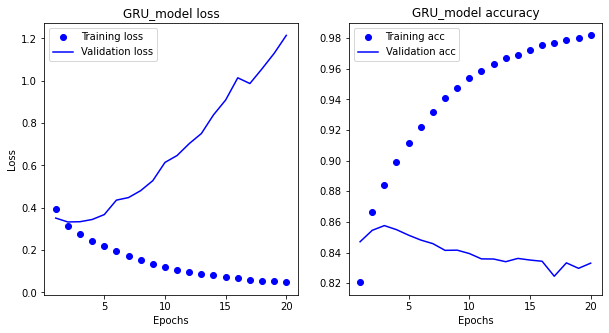

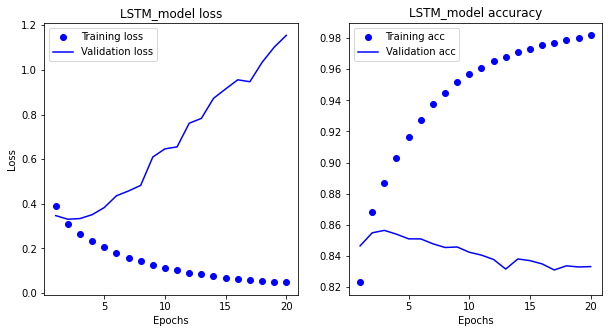

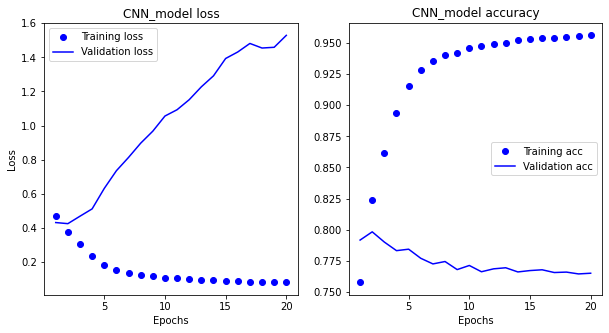

In [220]:
for model, history in zip(models, histories):
    plt.figure(figsize=(10, 5))
    plot_history(model, history)
    plt.show()

In [266]:
for model in models:
    best_model = tf.keras.models.load_model(f"{model.name}.keras")
    test_loss, test_accuracy = best_model.evaluate(X_test,  y_test, verbose=2)

    print(f"[{model.name}] {test_loss=}, {test_accuracy=}\n\n")

1537/1537 - 3s - loss: 0.3362 - accuracy: 0.8528
[GRU_model] test_loss=0.3361831307411194, test_accuracy=0.8527575135231018


1537/1537 - 3s - loss: 0.3349 - accuracy: 0.8537
[LSTM_model] test_loss=0.3349301517009735, test_accuracy=0.8536525964736938


1537/1537 - 2s - loss: 0.4284 - accuracy: 0.7954
[CNN_model] test_loss=0.4283751845359802, test_accuracy=0.7953903079032898




# 7) 학습된 Embedding 레이어 분석

In [270]:
import os

best_lstm_model = tf.keras.models.load_model("LSTM_model.keras")

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/nsmc_word2vec.txt'

with open(word2vec_file_path, 'w') as f:
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
    vectors = best_lstm_model.get_weights()[0]
    for i in range(4, vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))

In [272]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

lstm_word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
lstm_word_vectors.similar_by_word("싸움")

[('당함', 0.877016007900238),
 ('명작', 0.8660417795181274),
 ('정무문', 0.8579185605049133),
 ('내린', 0.8579135537147522),
 ('이만', 0.8577544689178467),
 ('련지', 0.8569226861000061),
 ('걸작', 0.8558192849159241),
 ('치즈', 0.8533986210823059),
 ('해냈', 0.8519948720932007),
 ('봐야', 0.8519643545150757)]

# 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [229]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'

word2vectors = Word2VecKeyedVectors.load(word2vec_file_path)
word2vectors.wv["끝"]

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [277]:
# 바닥부터 만든 embdding은 일반적이지 않은, 리뷰 문장이라는 정해진 문맥 내에서 유사 단어를 가져온다.
# pretrained embedding의 경우 보다 일반적인 문맥에 맞는 유사 단어를 가져온다.
for non_pretrained, pretrained in zip(
    lstm_word_vectors.similar_by_word("싸움"), 
    word_vectors.wv.similar_by_word("싸움")):

    print(non_pretrained, pretrained)

('당함', 0.877016007900238) ('격전', 0.8050743341445923)
('명작', 0.8660417795181274) ('말싸움', 0.7830536365509033)
('정무문', 0.8579185605049133) ('대결', 0.779976487159729)
('내린', 0.8579135537147522) ('추격전', 0.7779183983802795)
('이만', 0.8577544689178467) ('몸싸움', 0.7770674228668213)
('련지', 0.8569226861000061) ('말다툼', 0.7768386006355286)
('걸작', 0.8558192849159241) ('신경전', 0.7767255306243896)
('치즈', 0.8533986210823059) ('언쟁', 0.7748841643333435)
('해냈', 0.8519948720932007) ('일전', 0.7747855186462402)
('봐야', 0.8519643545150757) ('교전', 0.7501595616340637)


In [230]:
vocab_size = len(word_to_index)
word_vector_dim = 100

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [250]:
from tensorflow.keras.initializers import Constant

model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, word_vector_dim, 
                           embeddings_initializer=Constant(embedding_matrix),
                           trainable=True),
    keras.layers.LSTM(30),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
])

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, None, 100)         1000300   
_________________________________________________________________
lstm_15 (LSTM)               (None, 30)                15720     
_________________________________________________________________
dense_58 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 31        
Total params: 1,016,981
Trainable params: 1,016,981
Non-trainable params: 0
_________________________________________________________________


In [251]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM_model_fine_tuning.keras",
                                       monitor="val_loss",
                                       save_best_only=True)
]
    
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(X_valid, y_valid),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/20
1563/1563 [==============================] - 12s 6ms/step - loss: 0.4421 - accuracy: 0.7901 - val_loss: 0.3743 - val_accuracy: 0.8314
Epoch 2/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.3300 - accuracy: 0.8563 - val_loss: 0.3410 - val_accuracy: 0.8480
Epoch 3/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.2916 - accuracy: 0.8767 - val_loss: 0.3359 - val_accuracy: 0.8550
Epoch 4/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.2647 - accuracy: 0.8885 - val_loss: 0.3448 - val_accuracy: 0.8526
Epoch 5/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.2421 - accuracy: 0.9005 - val_loss: 0.3414 - val_accuracy: 0.8562
Epoch 6/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.2212 - accuracy: 0.9112 - val_loss: 0.3643 - val_accuracy: 0.8543
Epoch 7/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.2014 - accuracy: 0.9203 - val_loss: 0.3763 - val_ac

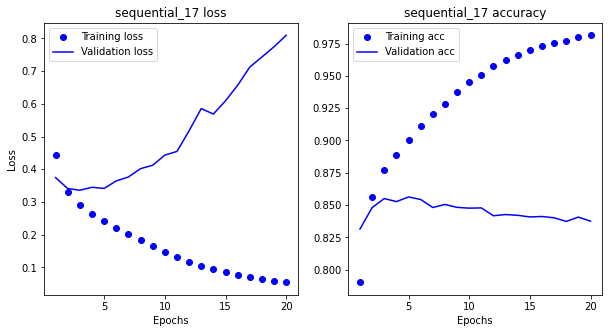

In [252]:
plt.figure(figsize=(10, 5))
plot_history(model, history)

In [254]:
best_model = tf.keras.models.load_model("LSTM_model_fine_tuning.keras")
test_loss, test_accuracy = best_model.evaluate(X_test,  y_test, verbose=2)

print(f"{test_loss=}, {test_accuracy=}")

1537/1537 - 4s - loss: 0.3405 - accuracy: 0.8515
test_loss=0.3404850661754608, test_accuracy=0.851455569267273


---

# 회고

- RNN 계열인 GRU, LSTM 모델과 비 RNN 계열 모델을 비교하고자 CNN 모델을 사용하여 실험을 진행했다. 
- GRU, LSTM, CNN을 사용하여 모델 학습을 진행하고 이 결과를 토대로 성능이 가장 좋은 모델을 선정한 뒤 pretrained embedding을 사용하여 성능을 추가로 비교하였다.

| | GRU | LSTM | CNN | LSTM with Pretrained Embedding |
| - | - | - | - | - |
| Loss | 0.3361 | 0.3349 | 0.4283 | 0.3404 |
| Accuracy | 0.8527 | 0.8536 | 0.7953 | 0.8514 |

- pretrained embedding을 사용하면 성능이 좋아질줄 알았는데 그렇지 않았다.
  - 단순한 task에 비해 embedding dimension이 필요이상으로 커서 그런것이 아닐까 라는 추측을 해본다.
- 나중에 여유가 된다면 Transformer 계열 모델로 성능을 비교해보면 좋을 것 같다.